In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from models.CNN_SE_model import CNN_SE
from models.CNN_model import CNN
from copy import deepcopy
from tqdm import tqdm
import time
from datetime import datetime, timedelta

In [2]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

IMAGE_FOLDER = 'images'
# IMAGE_FOLDER = 'example_images'
dataset = ImageFolder(root=f'./preprocessed-data/{IMAGE_FOLDER}', transform=data_transforms)
print(len(dataset), dataset.classes)
num_of_classes = len(dataset.classes)

14000 ['A300', 'A310', 'A320', 'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'Aethopyga Siparaja', 'Aix Sponsa', 'Alca Torda', 'An-12', 'Anastomus Oscitans', 'Anser Caerulescens', 'Ara Militaris', 'Aramus Guarauna', 'Argusianus Argu', 'BAE 146', 'BAE-125', 'Baryphthengus Martii', 'Beechcraft 1900', 'Boeing 707', 'Boeing 717', 'Boeing 727', 'Boeing 737', 'Boeing 747', 'Boeing 757', 'Boeing 767', 'Boeing 777', 'Buteo Jamaicensis', 'C-130', 'C-47', 'CRJ-200', 'CRJ-700', 'Calidris Canutus', 'Cardinalis Sinuatus', 'Catharus Fuscescens', 'Cessna 172', 'Cessna 208', 'Cessna Citation', 'Ceuthmochares Aereus', 'Challenger 600', 'Chamaea Fasciata', 'Cinnyricinclus Leucogaster', 'Colaptes Auratus', 'Colaptes Campestris', 'Columba Livia', 'Columba Livia Domestica', 'Cyanocorax Chrysops', 'DC-10', 'DC-3', 'DC-6', 'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'DR-400', 'Dash 8', 'Dendrocitta Vagabunda', 'Dornier 328', 'EMB-120', 'Embraer E-Jet', 'Embraer ERJ 145', 'Embraer Legacy 600', 'Eolophus Roseicap

In [3]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


In [4]:
model_cnn = CNN(num_of_classes).to(device)
model_cnn_se = CNN_SE(num_of_classes).to(device)
# print(model_cnn, model_cnn_se)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.0004)
optimizer_cnn_se = optim.Adam(model_cnn_se.parameters(), lr=0.0004)

best_cnn_acc = -1
best_cnn_se_acc = -1
best_cnn = None
best_cnn_se = None
cnn_acc_record = {'train': [], 'val': []}
cnn_se_acc_record = {'train': [], 'val': []}

In [5]:
def train(epoch):
    model_cnn.train()
    model_cnn_se.train()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    for x,y in train_loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)
        
        optimizer_cnn.zero_grad()
        optimizer_cnn_se.zero_grad()

        assert str(x.device) == str(y.device) == str(device), f"x: {x.device}, y: {y.device}, device: {device}"
        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)

        loss_cnn = criterion(y_hat_cnn, y)
        loss_cnn_se = criterion(y_hat_cnn_se, y)

        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

        loss_cnn.backward()
        loss_cnn_se.backward()

        optimizer_cnn.step()
        optimizer_cnn_se.step()

        # print(f"Epoch: {epoch}, CNN loss: {loss_cnn.item()}, CNN-SE loss: {loss_cnn_se.item()}")
        
    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['train'].append(cnn_acc)
    cnn_se_acc_record['train'].append(cnn_se_acc)

    print(f'epoch: {epoch:>3d} training accuracy  | CNN: {round(cnn_acc, 5):.05f} CNN-SE: {round(cnn_se_acc, 5):.05f}')

In [6]:
def validation(epoch, best_acc, best_model):
    model_cnn.eval()
    model_cnn_se.eval()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    with torch.no_grad():
        for x,y in val_loader:
            x: torch.Tensor = x.to(device)
            y: torch.Tensor = y.to(device)

            y_hat_cnn = model_cnn(x)
            y_hat_cnn_se = model_cnn_se(x)
            correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
            correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
            total_ct += y.size(0)

    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['val'].append(cnn_acc)
    cnn_se_acc_record['val'].append(cnn_se_acc)

    best_cnn_acc, best_cnn_se_acc = best_acc
    best_cnn, best_cnn_se = best_model
    if cnn_acc > best_cnn_acc:
        best_cnn_acc = cnn_acc
        best_cnn = deepcopy(model_cnn.state_dict())
    
    if cnn_se_acc > best_cnn_se_acc:
        best_cnn_se_acc = cnn_se_acc
        best_cnn_se = deepcopy(model_cnn_se.state_dict())
    

    print(f'epoch: {epoch:>3d} validation accuracy| CNN: {round(cnn_acc, 5):.05f} CNN-SE: {round(cnn_se_acc, 5):.05f}')
    return (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se)

In [7]:
EPOCHS = 20
starttime = time.time_ns()
for epoch in range(EPOCHS):
    train(epoch)
    (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se) = validation(epoch, (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se))
print(f"Total Time: {timedelta(milliseconds=((time.time_ns() - starttime) / 1000000))} seconds")

epoch:   0 training accuracy  | CNN: 0.03845 CNN-SE: 0.03798
epoch:   0 validation accuracy| CNN: 0.05643 CNN-SE: 0.06429
epoch:   1 training accuracy  | CNN: 0.08988 CNN-SE: 0.08917
epoch:   1 validation accuracy| CNN: 0.09607 CNN-SE: 0.08750
epoch:   2 training accuracy  | CNN: 0.13060 CNN-SE: 0.13143
epoch:   2 validation accuracy| CNN: 0.12107 CNN-SE: 0.12393
epoch:   3 training accuracy  | CNN: 0.16952 CNN-SE: 0.16702
epoch:   3 validation accuracy| CNN: 0.15286 CNN-SE: 0.16750
epoch:   4 training accuracy  | CNN: 0.21750 CNN-SE: 0.21560
epoch:   4 validation accuracy| CNN: 0.19893 CNN-SE: 0.18786
epoch:   5 training accuracy  | CNN: 0.26536 CNN-SE: 0.25940
epoch:   5 validation accuracy| CNN: 0.22679 CNN-SE: 0.22214
epoch:   6 training accuracy  | CNN: 0.30381 CNN-SE: 0.29607
epoch:   6 validation accuracy| CNN: 0.23679 CNN-SE: 0.23643
epoch:   7 training accuracy  | CNN: 0.34476 CNN-SE: 0.34226
epoch:   7 validation accuracy| CNN: 0.29679 CNN-SE: 0.28321
epoch:   8 training accu

In [8]:
model_cnn.load_state_dict(best_cnn)
model_cnn_se.load_state_dict(best_cnn_se)
model_cnn.eval()
model_cnn_se.eval()
correct_cnn = 0
correct_cnn_se = 0
total_ct = 0
with torch.no_grad():
    for x,y in test_loader:
        x: torch.Tensor = x.to(device)
        y: torch.Tensor = y.to(device)

        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)
        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

cnn_acc = correct_cnn / total_ct
cnn_se_acc = correct_cnn_se / total_ct

torch.save(model_cnn, "saved-models/cnn.pt")
torch.save(model_cnn_se, "saved-models/cnn-se.pt")

print(f'test accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')


test accuracy| CNN: 0.46036 CNN-SE: 0.42607


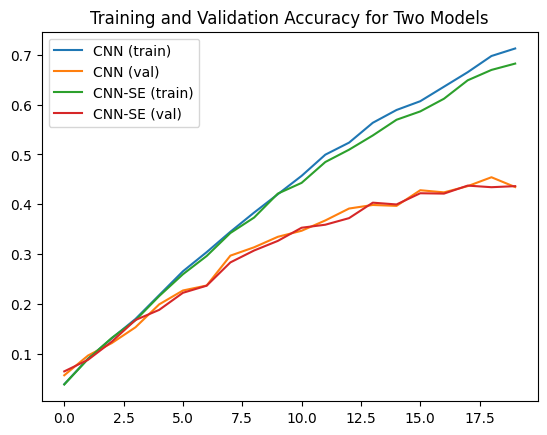

In [9]:
plt.plot(cnn_acc_record['train'], label='CNN (train)')
plt.plot(cnn_acc_record['val'], label='CNN (val)')

plt.plot(cnn_se_acc_record['train'], label='CNN-SE (train)')
plt.plot(cnn_se_acc_record['val'], label='CNN-SE (val)')

plt.title('Training and Validation Accuracy for Two Models')
plt.legend()

plt.show()
